# Kulo

## 1. Import geojson
According to Wikipedia, "GeoJSON is an open standard format designed for representing simple geographical features, along with their non-spatial attributes. It is based on the JSON format."

In [27]:
import geojson

## 2. Create load_data function to load geojson data
load_data(filename) is a simple wrapper around the Python File I/O that uses geojson to load the data into a dictionary

In [28]:
def load_data(filename):
    """
    Loads GeoJson Data from "filename"
    """
    with open(filename) as f:
        data = geojson.load(f)
    return data


## 3. Load data from WA DNR 1970-2007 fire statistics
source: https://data-wadnr.opendata.arcgis.com/datasets/dnr-fire-statistics-1970-2007-1

In [29]:
older_fire_data = load_data("data/DNR_Fire_Statistics_1970-2007.geojson")

## 3.5. load data from WA DNR 2008-present fire statistics
source: https://data-wadnr.opendata.arcgis.com/datasets/dnr-fire-statistics-2008-present-1

In [30]:
newer_fire_data = load_data("data/DNR_Fire_Statistics_2008_-_Present.geojson")

## 4. Pull out "features" section of data (that's where fire data is)

In [31]:
old_fire_data = older_fire_data["features"]
new_fire_data = newer_fire_data["features"]

## 4.5. Examine fire data and determine the parts we need.
As we can see, each fire has a "geometry" and "properties" attribute. From these, we want to extract the "coordinates" from "geometry", "ACRES_BURNED" from "properties", and "START_DT" from "properties" 

In [33]:
print(old_fire_data[1])

{"geometry": {"coordinates": [-117.078338, 47.837034], "type": "Point"}, "properties": {"ACRES_BURNED": 0.1, "COUNTY_LABEL_NM": "SPOKANE", "FIREEVNT_CLASS_LABEL_NM": "Classified", "FIREEVNT_NM": null, "FIREGCAUSE_LABEL_NM": "Recreation", "OBJECTID": 2, "START_DT": "1974-10-12T08:00:00Z"}, "type": "Feature"}


In [34]:
print(new_fire_data[1])

{"geometry": {"coordinates": [-120.916389, 45.904957], "type": "Point"}, "properties": {"ACRES_BURNED": 0.25, "BURNESCAPE_RSN_LABEL_NM": "Extinguish", "BURN_MERCH_AREA": null, "BURN_NONSTOCK_AREA": 0.25, "BURN_REPROD_AREA": null, "CONTROL_DT": "2017-05-23T00:00:00Z", "CONTROL_TM": "1935", "COUNTY_LABEL_NM": "KLICKITAT", "DSCVR_DT": "2017-05-23T00:00:00Z", "DSCVR_TM": "1650", "FIREEVENT_ID": 50035, "FIREEVNT_CLASS_CD": 1, "FIREEVNT_CLASS_LABEL_NM": "Classified", "FIREGCAUSE_LABEL_NM": "Debris Burn", "FIRESCAUSE_LABEL_NM": "None", "FIRE_OUT_DT": "2017-05-25T00:00:00Z", "FIRE_OUT_TM": "1300", "FIRE_RGE_DIR_FLG": "E", "FIRE_RGE_FRACT_NO": 0, "FIRE_RGE_WHOLE_NO": 15, "FIRE_SECT_NO": 22, "FIRE_TWP_FRACT_NO": 0, "FIRE_TWP_WHOLE_NO": 5, "INCIDENT_ID": 49868, "INCIDENT_NM": "Turkey Ranch", "INCIDENT_NO": 7, "LAT_COORD": 45.904947, "LON_COORD": -120.916377, "NON_DNR_RES_ORDER_NO": null, "OBJECTID": 2, "PROTECTION_TYPE": "DNR Protection FFPA", "REGION_NAME": "SOUTHEAST", "RES_ORDER_NO": "WA-SES-0

## 5. Ensure both datasets are imported by checking total number of fires 
Here, we see that the 1970-2007 data has nearly 40,000 fires, where the 2008-present set has just over 20,000. We want to combine these to get the full range of wildfire activity since 1970.

In [35]:
# get total number of fires
old_total = len(old_fire_data)
new_total = len(new_fire_data)
print(old_total, new_total, old_total + new_total)

38116 20703 58819


## 6. Make clean dataset from both pieces of data (only data-points we need)

The data we need to extract is: Date, Acreage, Coordinates

In [36]:
cleaned_fire_data = []
for fire in old_fire_data:
    date = fire["properties"]["START_DT"]
    acres = fire["properties"]["ACRES_BURNED"]
    lon = fire["geometry"]["coordinates"][0]
    lat = fire["geometry"]["coordinates"][1]
    cleaned_fire_data.append((date, acres, lat, lon))

for fire in new_fire_data: 
    date = fire["properties"]["START_DT"]
    acres = fire["properties"]["ACRES_BURNED"]
    lon = fire["geometry"]["coordinates"][0]
    lat = fire["geometry"]["coordinates"][1]
    cleaned_fire_data.append((date, acres, lat, lon))

In [37]:
print(len(cleaned_fire_data))

58819


## 7. Import csv (comma-separated values)
The CSV package is used to write a comma-separated file of the cleaned data, for future use.

In [38]:
import csv

## 8. Save cleaned data to csv
Using csv.writer(), we write a single row at a time while iterating over the nearly 60,000 fires in Washington

In [39]:
with open('data/clean_fire_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile,)
    writer.writerow(("date", "acres", "lat", "lon"))
    for fire in cleaned_fire_data:
        writer.writerow(fire)

## 9. Import matplotlib (for visualizing data)
From the Matplotlib website, "Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python."

In [40]:
import matplotlib.pyplot as plt

## 10. Import numpy (for arrays and matrix math)
We mostly need numpy for their np.array() function.

In [41]:
import numpy as np

## 11. Create numpy array from fire data

In [42]:
np_fire_data = np.array(cleaned_fire_data)

## 12. Access column from the np array using syntax below
np_fire_data\[:,1\] is the basic structure to extract all values from column 1 into a 1-d numpy array.

In [72]:
acres = np_fire_data[:,1]
print(acres)

['0.01' '0.1' '40.0' ... '0.47' '0.5' '0.0']


## 13. Convert ISO8601 format date to epoch
The DNR datasets have the start date for each fire in the ISO8601 format. For use in matplotlib, we need to switch this to the epoch format and rebuild the 1-d numpy array.

In [70]:
import dateutil.parser as dp

dates = np_fire_data[:, 0]
new_dates = []
for date in dates:
    new_dates.append(dp.parse(date).timestamp())
np_new_dates = np.array(new_dates)
print(np_new_dates)

[1.1874240e+09 1.5079680e+08 1.1416320e+08 ... 1.4992416e+09 1.5868512e+09
 1.4653728e+09]


## 14. Get coordinate point columns
Using the same strategy as above, albeit less complicated, extract the coordinate values into their own numpy arrays.

In [69]:
lats = np_fire_data[:,2]
print(lats)
longs = np_fire_data[:,3]
print(longs)

['46.473463' '47.837034' '47.837034' ... '47.552689' '48.672689'
 '47.350066']
['-123.941779' '-117.078338' '-117.078338' ... '-117.182356' '-122.315778'
 '-118.73053']


## 15. Import matplotlib dates (for plotting dates on histogram)
The mdates.epoch2num() function converts a date in the epoch format to something a little more usable in matplotlib.

In [58]:
import matplotlib.dates as mdates

In [59]:
# convert the epoch format to matplotlib date format 
mpl_dates = mdates.epoch2num(np_new_dates)

## 16. Plot "wildfires by year" in histogram
Here, we use some of the features of pyplot, most importantly hist(), which generates a histogram. The x-axis is years, the y-axis is number of fires.

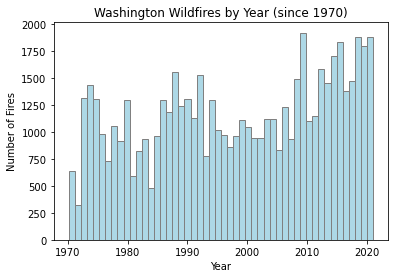

In [66]:
fig, ax = plt.subplots(1,1)
ax.hist(mpl_dates, bins=50, color='lightblue', edgecolor='grey')
locator = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
ax.set_title("Washington Wildfires by Year (since 1970)")
ax.set_xlabel('Year')  # Add an x-label to the axes.
ax.set_ylabel('Number of Fires')  # Add a y-label to the axes.
plt.savefig("img/fires_by_year.png", transparent=False, facecolor='w', edgecolor='w' )
plt.show()
